# Toxic comment classification - kaggle challenge 

In [2]:
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import pandas as pd
import re
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,log_loss
import lightgbm as lgb


train=pd.read_csv('D:\\workshop\\ML\\kaggle\\Toxic classification\\train.csv', nrows = 5000) #d.columns.values
classes=['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate']
ps=SnowballStemmer('english')
s=set(stopwords.words('english'))
train.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Finding if dataset has null values

In [3]:
train.apply(lambda x: sum(x.isnull()), axis=0)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# Data preprocessing 

In [4]:
def filter_comment(d):
    vocab=[]
    for i in range(d.shape[0]):
        comment=re.sub('[^a-zA-Z]',' ',d['comment_text'][i])
        comment=comment.lower().split()
        comment=[ps.stem(word) for word in comment if word not in s]
        comment=' '.join(comment)
        vocab.append(comment)
    return vocab 

train_data=filter_comment(train)   
vector=TfidfVectorizer(smooth_idf=True,sublinear_tf=True,max_df=.75, analyzer='char',ngram_range=(1,2))    
train_vector=vector.fit_transform(train_data)

confusion matrix for all classes

In [5]:

def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    #import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

# Model selection 
Votedclassifier using Logisitc Regression with different hyperparameters 
Light gradient boosting with hyperparameters of alpha=.1,no of leaves=41 gives best result 
Blend of two models are taken for predecting the class 

Class:toxic


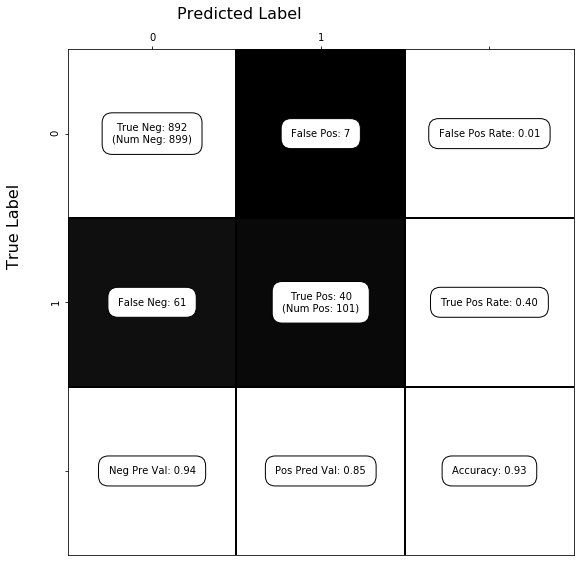

0.878610997918
log loss of class:  toxic 0.20722261661
Class:severe_toxic


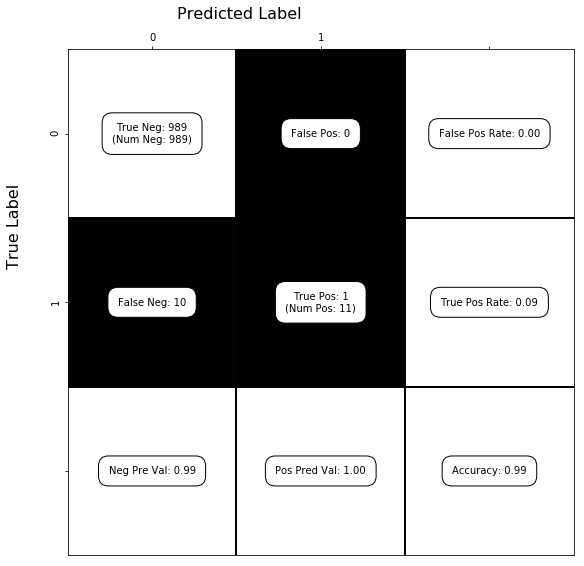

0.994852468058
log loss of class:  severe_toxic 0.0259632608946
Class:obscene


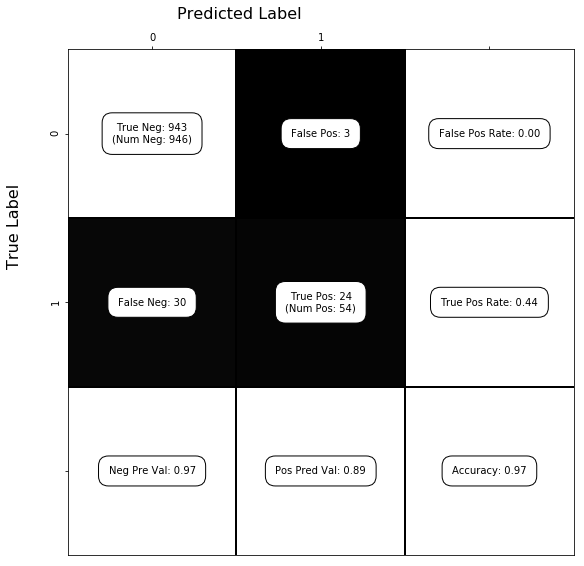

0.974336387127
log loss of class:  obscene 0.0816009884285


C:\Users\lbhar\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Class:threat


C:\Users\lbhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


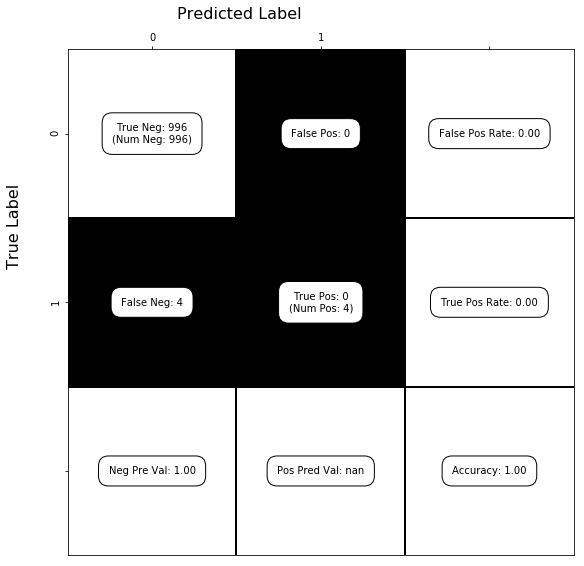

0.871234939759
log loss of class:  threat 0.0247410571674
Class:insult


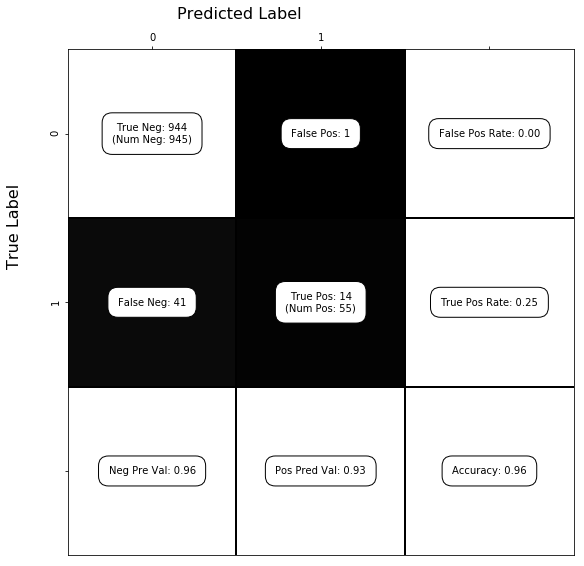

0.931274651275
log loss of class:  insult 0.122788848999
Class:identity_hate


C:\Users\lbhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


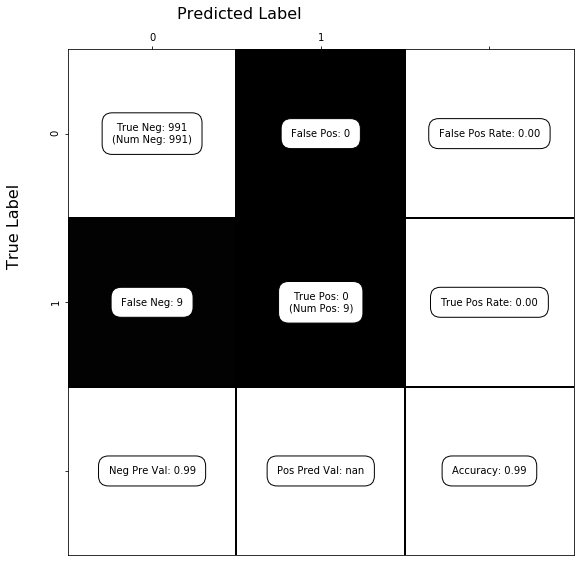

0.918600739993
log loss of class:  identity_hate 0.0402448473726
Total average score is 0.9281516973550418


In [6]:
clf1=LogisticRegression(C=3,solver= 'liblinear')
clf2=LogisticRegression(C=3,solver= 'sag')
clf3=LogisticRegression(C=3,solver= 'lbfgs')
clf4=LogisticRegression(C=1,solver= 'newton-cg')

clf=VotingClassifier(estimators=[('lr', clf1), ('gnb', clf2), ('rf', clf3),('rg', clf4)], voting='soft')

fpr = dict()
tpr = dict()
roc_auc = dict()
scores = []
for c in classes: 
    X_train, X_test, Y_train, Y_test = train_test_split(train_vector,train.loc[:,c].values,test_size=0.2)
    clf=clf.fit(X_train,Y_train)
    d_train = lgb.Dataset(X_train, label=Y_train)
    params = {"objective": "binary",
        'metric': {'auc'},
        "boosting_type": "gbdt",
        "verbosity": -1,
        "num_threads": 4,
        "bagging_fraction": 0.8,
        "feature_fraction": 0.8,
        "learning_rate": 0.1,
        "num_leaves": 41,
        "verbose": -1,
        "min_split_gain": .1,
        "reg_alpha": .1}
    classifier = lgb.train( params=params,
                    train_set=d_train,
                    num_boost_round=500,
                    verbose_eval=0)
    
    prob_lgb= classifier.predict(X_test)
    prob_vcl=clf.predict_proba(X_test)
    predict_class=clf.predict(X_test) #predicting class for each tuple for confusion matrix 
    prob=(prob_lgb+prob_vcl[:,1])/2
    fpr[c], tpr[c], _ = roc_curve(Y_test,prob)
    roc_auc[c] = auc(fpr[c], tpr[c])
    scores.append(roc_auc[c]) 
    cm=confusion_matrix(Y_test,predict_class);
    print("Class :" +c)
    show_confusion_matrix(cm,['0','1'])
    print("ROC_auc :",roc_auc[c])
    print("log loss of class: ",c,log_loss(Y_test, prob))
    print("\n")
print('Total average score is {}'.format(np.mean(scores)))    

#ROC for various classes

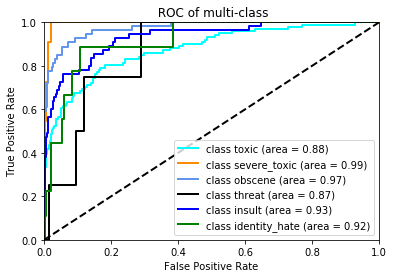

In [7]:
plt.figure()
lw = 2
colors = ['aqua', 'darkorange', 'cornflowerblue','black', 'blue','green']
for i, col in zip(classes,colors):
    plt.plot(fpr[i], tpr[i], color=col, lw=lw,
             label='class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC of multi-class')
plt.legend(loc="lower right")
plt.show()